# Making the first request

The page contains university names and their respective links. We will parse these names and links.

In [21]:
import requests
s = requests.get('https://yokatlas.yok.gov.tr/lisans-bolum.php?b=10024')

# Parsing university names and links

We will filter the hrefs with the substring 'lisans.php?y=' and extract the information to a list of tuples that contain university ids and names.

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(s.text)
uniList = [(i.attrs['href'].split('=')[-1], i.findChild('div').text) for i in soup.find_all('a')\
           if 'lisans.php?y=' in i.attrs['href']]

# Parsing relevant data from individual university pages

We are asked to retrieve four pieces of data from the individual university programs. Each piece of information will be retrieved from different dynamically loaded html pages. This data will be loaded into a dictionary with the keys being university ids.

In [110]:
uniData = {}

In [ ]:
from time import sleep
dynamicContentLink = 'https://yokatlas.yok.gov.tr/2017/content/lisans-dynamic/{}.php?y={}'
pageLink = 'https://yokatlas.yok.gov.tr/2017/lisans.php?y={}'
for uniID, uniName in uniList:
    if uniID in uniData.keys():
        continue

    sehirPage = requests.get(pageLink.format(uniID))
    sehirSoup = BeautifulSoup(sehirPage.text)
    sehir = sehirSoup.findChild('h3').text.strip().split()[-1][1:-1]
    if sehir == '':
        continue

    kontenjanPage = requests.get(dynamicContentLink.format('1000_1', uniID))
    kontenjanSoup = BeautifulSoup(kontenjanPage.text)
    c = kontenjanSoup.findChild('td', text='Toplam Kontenjan')
    if c == None:
        kontenjan = 0
    else:
        kontenjanStr = c.fetchNextSiblings()[0].text
        kontenjan = int(kontenjanStr) if kontenjanStr != '' else 0

    avgnetPage = requests.get(dynamicContentLink.format('1210a', uniID))
    avgnetSoup = BeautifulSoup(avgnetPage.text)
    c = avgnetSoup.findChild('td', text='YGS Matematik (40 soruda)')
    if c == None:
        avgnet = 0.0
    else:
        avgnetStr = c.fetchNextSiblings()[0].text
        avgnet = float(avgnetStr.replace(',', '.') if avgnetStr != '' else 0.0)

    lowestrankPage = requests.get(dynamicContentLink.format('1070', uniID))
    lowestrankSoup = BeautifulSoup(lowestrankPage.text)
    c = lowestrankSoup.findChild('td', text='Yerleştiği Başarı Sırası')
    if c == None:
        lowestrank = 0
    else:
        lowestrankStr = c.fetchNextSiblings()[0].text
        lowestrank = int(lowestrankStr.replace('.', '')) if lowestrankStr != '' else 0

    print(uniID, uniName, sehir, kontenjan, avgnet, lowestrank)
    uniData[uniID] = {'isim':uniName, 'sehir':sehir, 'kontenjan':kontenjan, 'ortalama':avgnet, 'tabansiralama': lowestrank}
    
    sleep(1)

In [208]:
bolgeler = {'Karadeniz': ['RİZE', 'TRABZON', 'ARTVİN', 'SİNOP', 'TOKAT', 'ÇORUM', 'AMASYA', 'SAMSUN', 'ZONGULDAK', 'BOLU', 'DÜZCE', 'KARABÜK', 'BARTIN', 'KASTAMONU', 'BAYBURT', 'GİRESUN', 'GÜMÜŞHANE', 'ORDU'], 'Marmara': ['EDİRNE', 'KIRKLARELİ', 'TEKİRDAĞ', 'İSTANBUL', 'KOCAELİ', 'YALOVA', 'SAKARYA', 'BİLECİK', 'BURSA', 'BALIKESİR', 'ÇANAKKALE'], 'Doğu Anadolu': ['AĞRI', 'ARDAHAN', 'BİNGÖL', 'BİTLİS', 'ELAZIĞ', 'ERZİNCAN', 'ERZURUM', 'HAKKARİ', 'IĞDIR', 'KARS', 'MALATYA', 'MUŞ', 'TUNCELİ', 'VAN', 'ŞIRNAK'], 'Akdeniz': ['ADANA', 'OSMANİYE', 'ANTALYA', 'BURDUR', 'HATAY', 'ISPARTA', 'İÇEL', 'KAHRAMANMARAŞ'], 'Güneydoğu Anadolu': ['ADIYAMAN', 'BATMAN', 'DİYARBAKIR', 'GAZİANTEP', 'KİLİS', 'MARDİN', 'SİİRT', 'ŞANLIURFA'], 'İç Anadolu': ['AKSARAY', 'ANKARA', 'ÇANKIRI', 'ESKİŞEHİR', 'KARAMAN', 'KIRIKKALE', 'KIRŞEHIR', 'KONYA', 'NEVŞEHİR', 'NİĞDE', 'SİVAS', 'YOZGAT', 'KAYSERİ'], 'Ege': ['İZMİR', 'MANİSA', 'AYDIN', 'DENİZLİ', 'KÜTAHYA', 'AFYONKARAHİSAR', 'UŞAK', 'MUĞLA']}

# Visualizing quotas and regions using boxplot

For every university, we first get its region using the previously crafted dictionary. Then we put its quota information into the correct list.

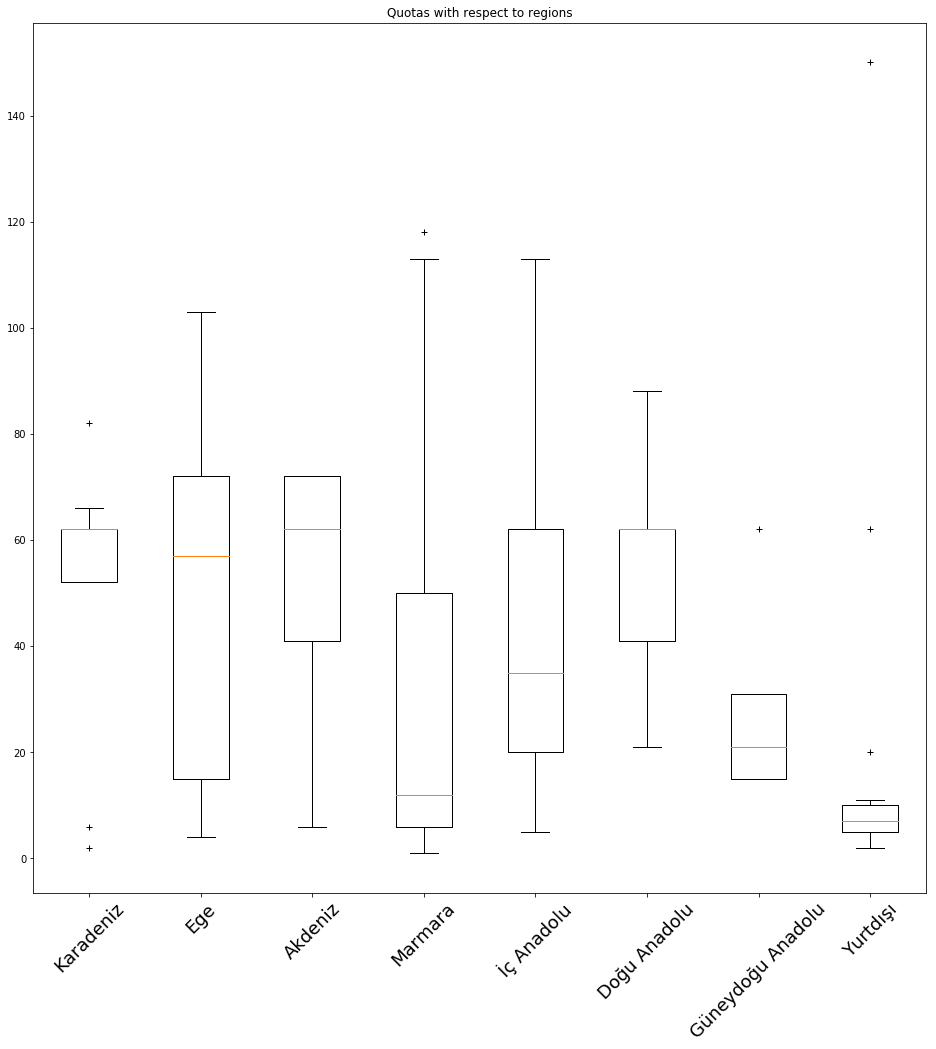

In [239]:
import matplotlib.pyplot as plt
import numpy as np

def findRegion(sehir):
    for region in bolgeler.keys():
        if sehir in bolgeler[region]:
            return region
    else:
        return "Yurtdışı"

bolgelerList = ['Karadeniz', 'Ege', 'Akdeniz', 'Marmara', 'İç Anadolu', 'Doğu Anadolu', 'Güneydoğu Anadolu', 'Yurtdışı']
# List of lists to keep quota data for each region
bolgelerData = [[] for _ in bolgelerList]

for entry in uniData:
    data = uniData[entry]
    index = bolgelerList.index(findRegion(data['sehir']))
    if data['kontenjan'] != 0:
        bolgelerData[index].append(data['kontenjan'])

# Plot
fig, ax1 = plt.subplots(figsize=(16, 16))
bp = ax1.boxplot(bolgelerData, notch=0, sym='+', vert=1, whis=1.5)
ax1.set_xlim(0.5, len(bolgelerList) + 0.5)
ax1.set_xticklabels(bolgelerList, rotation=45, fontsize=18)
ax1.set_title('Quotas with respect to regions')

plt.show()

# Visualizing the relation between average net math questions in YGS and lowest student rank using scatter plot

Finally we use average score and lowest student rank information to craft a scatter plot.

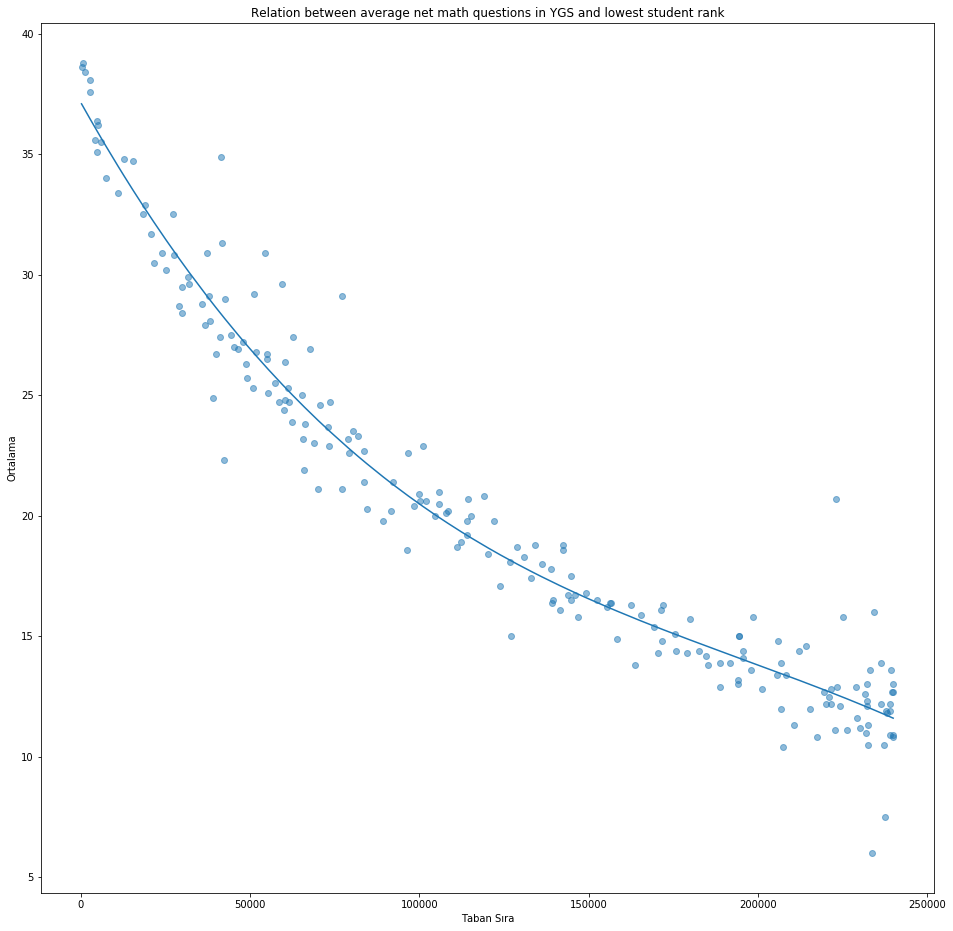

In [256]:
import numpy as np
import matplotlib.pyplot as plt
 
avgnetList = []
lowestRankList = []

for entry in uniData:
    data = uniData[entry]
    if data['ortalama'] == 0 or data['tabansiralama'] == 0:
        continue
    avgnetList.append(data['ortalama'])
    lowestRankList.append(data['tabansiralama'])

# Plot
plt.figure(figsize = (16, 16))
plt.scatter(lowestRankList, avgnetList, alpha=0.5)

# Calculate and plot the regression line
coeffs = np.polyfit(lowestRankList, avgnetList, 3)
y = np.polyval(coeffs, np.unique(lowestRankList))
plt.plot(np.unique(lowestRankList), y)

plt.title('Relation between average net math questions in YGS and lowest student rank')
plt.ylabel('Ortalama')
plt.xlabel('Taban Sıra')

plt.show()